In [1]:
from yahoo_fin import stock_info as si
from matplotlib import pyplot as plt 
import pandas_datareader as dr
import numpy as np
import pandas as pd

In [2]:
'''----// General input variables //----'''

company_ticker = 'CVX'
market_risk_premium = 0.059
debt_return = 0.01
long_term_growth = 0.01
tax_rate = 0.3
iterations = 1000

In [3]:
'''----// Get financial information from yahoo finance //----'''

income_statement_df = si.get_income_statement(company_ticker)

pars_df = income_statement_df.loc[['totalRevenue', 'ebit']]

input_df = pars_df.iloc[:, ::-1]

In [4]:
'''----// Calculate average revenue CAGR & EBIT margin //----'''

def get_cagr(past_revs):
    CAGR = (past_revs.iloc[0,3]/past_revs.iloc[0,0])**(1/4)-1
    return(CAGR)

def get_average_margin(past_ebit):
    margin = 0
    margin_lst = []
    for i in range(len(past_ebit.columns)):
        margin = past_ebit.iloc[1,i]/past_ebit.iloc[0,i]
    margin_lst.append(margin)
    return(sum(margin_lst)/len(margin_lst))


In [6]:
mean_cagr = get_cagr(input_df)
mean_margin = get_average_margin(input_df)

In [7]:
'''----// Create forecast function through which random variables will flow //----'''
def get_forecast(input_df, cagr, margin, long_term_growth):
    forecast_lst = []
    for i in range(6):
        if i < 5:
            forecast_lst.append(input_df.iloc[0,3]*(1+cagr)**(i+1)*margin)
        else:
            forecast_lst.append(input_df.iloc[0,3]*(1+cagr)**(i)*(1+long_term_growth)*margin)
    return forecast_lst

In [8]:
'''----// Get WACC and net debt //----'''

def get_wacc(company_ticker, market_risk_premium, debt_return, tax_rate):
    risk_free_rate_df = dr.DataReader('^TNX', 'yahoo') 
    risk_free_rate = (risk_free_rate_df.iloc[len(risk_free_rate_df)-1,5])/100
    equity_beta = si.get_quote_table('msft')['Beta (5Y Monthly)']
    equity_return = risk_free_rate+equity_beta*(market_risk_premium)
    balance_sheet_df = si.get_balance_sheet(company_ticker)
    short_term_debt_series = balance_sheet_df.loc['shortLongTermDebt']
    long_term_debt_series = balance_sheet_df.loc['longTermDebt']
    cash_series = balance_sheet_df.loc['cash']
    net_debt = short_term_debt_series.iloc[0] +  + long_term_debt_series.iloc[0] - cash_series.iloc[0]
    market_cap_str = si.get_quote_table(company_ticker)['Market Cap']
    market_cap_lst = market_cap_str.split('.')

    if market_cap_str[len(market_cap_str)-1] == 'T':
        market_cap_length = len(market_cap_lst[1])-1
        market_cap_lst[1] = market_cap_lst[1].replace('T',(12-market_cap_length)*'0')
        market_cap = int(''.join(market_cap_lst))

    if market_cap_str[len(market_cap_str)-1] == 'B':
        market_cap_length = len(market_cap_lst[1])-1
        market_cap_lst[1] = market_cap_lst[1].replace('B',(9-market_cap_length)*'0')
        market_cap = int(''.join(market_cap_lst))

    company_value = market_cap + net_debt
    WACC = market_cap/company_value * equity_return + net_debt/company_value * debt_return * (1-tax_rate)
    return WACC

In [9]:
def get_net_debt():
    
    balance_sheet_df = si.get_balance_sheet(company_ticker)
    short_term_debt_series = balance_sheet_df.loc['shortLongTermDebt']
    long_term_debt_series = balance_sheet_df.loc['longTermDebt']
    cash_series = balance_sheet_df.loc['cash']

    return short_term_debt_series.iloc[0] + long_term_debt_series.iloc[0] - cash_series.iloc[0]

In [10]:
mean_wacc = get_wacc(company_ticker, market_risk_premium, debt_return, tax_rate)

net_debt = get_net_debt()

In [11]:
'''----// Discount EBIT figures to arrive at the PV of the firm's cash flows //----'''

def discount(forecast, discount_rate, long_term_rate):
    discount_lst = []
    for x,i in enumerate(forecast):
        if x < 5:
            discount_lst.append(i/(1+discount_rate)**(x+1))
        else:
            discount_lst.append(i/(discount_rate-long_term_rate)*(1/(1+discount_rate)**5))
    return sum(discount_lst)

In [12]:
'''----// Run simulation and plot distribution of model forecasts //----'''

hist_lst = []

for i in range(iterations):
    cagr = np.random.normal(mean_cagr, 0.01)
    margin = np.random.normal(mean_margin, 0.005)
    long_term_rate = np.random.normal(long_term_growth, 0.001)
    discount_rate = np.random.normal(mean_wacc, 0.001)
    forecast = get_forecast(input_df, cagr, margin, long_term_rate)
    hist_lst.append(discount(forecast, discount_rate, long_term_rate)-net_debt)
hist_array = np.array(hist_lst)

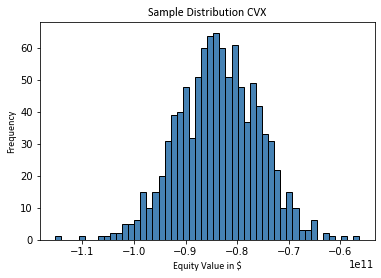

In [13]:
plt.hist(hist_array, bins=50, align='mid', color = 'steelblue', edgecolor='black')
plt.title('Sample Distribution ' + company_ticker, {'fontname':'Calibri'})
plt.xlabel('Equity Value in $', {'fontname':'Calibri'})
plt.ylabel('Frequency', {'fontname':'Calibri'})

plt.show()

In [15]:
mean = hist_array.mean()
standard_error = hist_array.std()/(iterations**(1/2))

lower_bound = mean-1.96*standard_error
upper_bound = mean+1.96*standard_error 

print(lower_bound)
print(upper_bound)

-84134424395.67332
-83171450217.52095
